In [1]:
import torch
import torch.nn as nn
import torch.utils.data as data
import torchvision
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from torchinfo import summary
import pandas as pd
from operator import itemgetter
import random
from tqdm.notebook import tqdm

In [2]:
cuda = torch.cuda.is_available()
print(f"Using GPU: {cuda}")

if cuda:
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

Using GPU: True


# Load Image data

In [3]:
image_path = r"E:\Letterboxd\Tensors BS 64 X"
df = pd.read_csv(r"C:\Users\rorin\Documents\Letterboxd\Data Mining\movie_data_cleaned.csv")
df_labels = df.drop(df.columns[[1,2,3,4,5,6,7,27,28]], axis = 1)

In [4]:
df.shape

(22969, 29)

In [5]:
df.head()

,id,name,link,img,genre,year,length,leading_genre,action,adventure,...,music,mystery,romance,science-fiction,thriller,tv-movie,war,western,nr assigned genres,img empty
0,0,Jojo Rabbit (2019) 4.06,/film/jojo-rabbit/,https://a.ltrbxd.com/resized/film-poster/4/4/4...,"['comedy', 'drama', 'war']",2019,108.0,comedy,0,0,...,0,0,0,0,0,0,1,0,3,False
1,1,The Lighthouse (2019) 4.05,/film/the-lighthouse-2019/,https://a.ltrbxd.com/resized/film-poster/4/3/3...,"['thriller', 'fantasy', 'drama', 'horror']",2019,109.0,thriller,0,0,...,0,0,0,0,1,0,0,0,4,False
2,2,Parasite (2019) 4.58,/film/parasite-2019/,https://a.ltrbxd.com/resized/film-poster/4/2/6...,"['comedy', 'drama', 'thriller']",2019,133.0,comedy,0,0,...,0,0,0,0,1,0,0,0,3,False
3,3,The Dark Knight (2008) 4.44,/film/the-dark-knight/,https://a.ltrbxd.com/resized/sm/upload/78/y5/z...,"['action', 'thriller', 'drama', 'crime']",2008,152.0,action,1,0,...,0,0,0,0,1,0,0,0,4,False
4,4,The Wolf of Wall Street (2013) 4.01,/film/the-wolf-of-wall-street/,https://a.ltrbxd.com/resized/film-poster/8/6/1...,"['comedy', 'drama', 'crime']",2013,180.0,comedy,0,0,...,0,0,0,0,0,0,0,0,3,False


# Plot some images with labels

In [6]:
example_X = torch.load(image_path + "\\0.pt")
example_y = torch.load(image_path.replace("X", "y") + "\\0.pt")
print(f"Shape of one X batch: {example_X.size()}")
print(f"Shape of one y batch: {example_y.size()}")

Shape of one X batch: torch.Size([64, 3, 345, 230])
Shape of one y batch: torch.Size([64, 19])


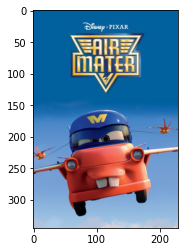

tensor([0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.])
Index(['action', 'adventure', 'animation', 'comedy', 'crime', 'documentary',
       'drama', 'family', 'fantasy', 'history', 'horror', 'music', 'mystery',
       'romance', 'science-fiction', 'thriller', 'tv-movie', 'war', 'western'],
      dtype='object')
Index(['animation', 'family'], dtype='object')


In [7]:
plt.imshow(example_X[3].permute(1,2,0))
plt.show()
print(example_y[3])
print(df_labels.columns[1:])
print(df_labels.columns[1:][[bool(x.item()) for x in example_y[3]]])

We see the boolean classes of the movie "Air Mater" and the corresponding genres. The genre should be "animation" and "family". Lets see if this is True:

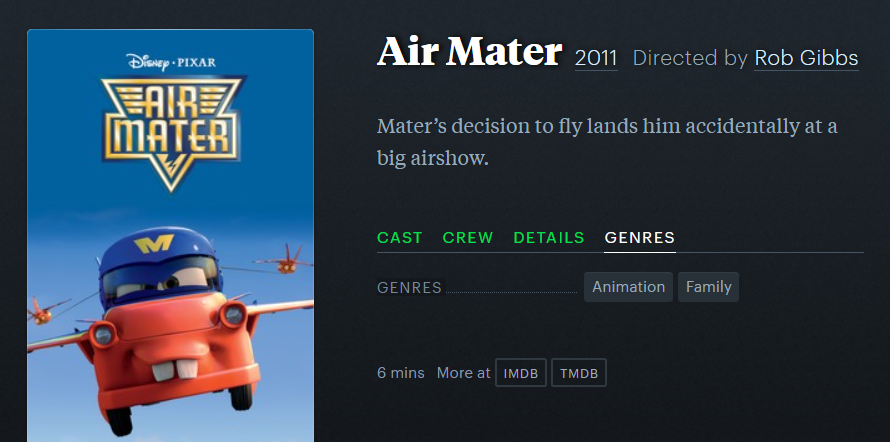

# Build network architecture

In [8]:
class CNN(torch.nn.Module):
    """
    Creating a CNN classifier for classifing movie genre by movie artwork
    """
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Sequential(nn.Conv2d(in_channels = 3,
                                            out_channels = 6,
                                            kernel_size = 5,
                                            stride = 5),
                                  nn.LeakyReLU(),
                                  nn.BatchNorm2d(6))

        self.conv2 = nn.Sequential(nn.Conv2d(in_channels = 6,
                                             out_channels = 8,
                                             kernel_size = 3,
                                             stride = 3,
                                             padding = (0, 1)),
                                   nn.LeakyReLU(),
                                   nn.BatchNorm2d(8)
                                  )

        self.conv3 = nn.Sequential(nn.Conv2d(in_channels = 8,
                                            out_channels = 10,
                                            kernel_size = (5,4),
                                            stride = 2,
                                            padding = (1, 0)),
                                   nn.LeakyReLU(),
                                  nn.BatchNorm2d(10))

        self.fc1 = nn.Linear(770, 256)
        self.fc2 = nn.Linear(256, 19)
        
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)

        out = out.view(out.size(0), -1)
        
        out = self.fc1(out)
        out = self.fc2(out)
        
        return out

# Transform with normalization and augmentation

In [9]:
transform = transforms.Compose([
    transforms.Normalize(mean = [0.4711, 0.4182, 0.3881], std = [0.3630, 0.3448, 0.3380]), #Calculated before
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(),
    transforms.RandomInvert()
])

# Split data 

In [10]:
files = os.listdir(image_path) #X and y file names are identically
train_files = files[:290]
val_files = files[290:]

# Loss on initialization model

In [11]:
init_model = CNN().to(device)
init_loss = []
init_criterion = torch.nn.BCEWithLogitsLoss()
init_model.eval()

with torch.no_grad():
    for train_file in tqdm(train_files):
        X = torch.load(image_path + f"\\{train_file}", device)
        X = transform(X)
        y = torch.load(r"E:\Letterboxd\Tensors BS 64 y" + f"\\{train_file}", device)

        out = init_model(X)
        loss = init_criterion(out, y.float())
        init_loss.append(loss)
        
print(f"Mean-Loss on init_model is: {sum(init_loss)/len(init_loss)}")

  0%|          | 0/290 [00:00<?, ?it/s]

Mean-Loss on init_model is: 0.6972297430038452


# Training loop

In [12]:
def train(model, epochs, lr, train_files, val_files, transform):
    train_start = time.time()    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.BCEWithLogitsLoss()
    loss_hist = []
    val_loss_hist = []
    
    print("Start training")
    
    for epoch in range(epochs):
        epoch_start = time.time()
        train_batch_loss_hist = []
        val_batch_loss_hist = []
        
        model.train()
        for train_file in train_files:
            X = torch.load(image_path + f"\\{train_file}", device)
            X = transform(X)
            y = torch.load(r"E:\Letterboxd\Tensors BS 64 y" + f"\\{train_file}", device)
            
            out = model(X)
            optimizer.zero_grad()
            loss = criterion(out, y.float())
            loss.backward()
            optimizer.step()
            train_batch_loss_hist.append(loss)
        
        model.eval()
        with torch.no_grad():
            for val_file in val_files:
                X = torch.load(image_path + f"\\{val_file}", device)
                X = transform(X)
                y = torch.load(r"E:\Letterboxd\Tensors BS 64 y" + f"\\{val_file}", device)
                out = model(X)
                loss = criterion(out, y.float())
                val_batch_loss_hist.append(loss)
            
        loss_hist.append(train_batch_loss_hist)
        val_loss_hist.append(val_batch_loss_hist)
        print(f'[{epoch+1}/{epochs}] Loss: {loss.item():.5f}. Epoch time: {time.time() - epoch_start:.1f}s.' )
    print(f"Finished training after {time.time() - train_start:.1f}s.")
    return loss_hist, val_loss_hist

# Overfit on small dataset, check if model is capable enough

In [13]:
epochs = 5
lr = 0.0005
nr_batches = 1
overfit_model = CNN().to(device)

of_loss_hist, of_val_loss_hist = train(overfit_model, epochs, lr, train_files[:nr_batches], val_files, transform)

Start training
[1/5] Loss: 0.69197. Epoch time: 9.6s.
[2/5] Loss: 0.69047. Epoch time: 2.7s.
[3/5] Loss: 0.68733. Epoch time: 3.0s.
[4/5] Loss: 0.68589. Epoch time: 2.6s.
[5/5] Loss: 0.68187. Epoch time: 2.8s.
Finished training after 20.8s.


In [14]:
def plot_train_val_loss(loss_hist, val_hist):
    """
    Both parameters expected to be list of lists, where each element of sub-lists is a float of a minibatch-loss
    """
    epoch_loss_train = [(sum(x)/len(x)).item() for x in loss_hist]
    epoch_loss_val = [(sum(x)/len(x)).item() for x in val_hist]

    plt.plot(range(len(epoch_loss_train)), epoch_loss_train, label = "Train")
    plt.plot(range(len(epoch_loss_val)), epoch_loss_val, label = "Validation")
    plt.legend()
    plt.show()

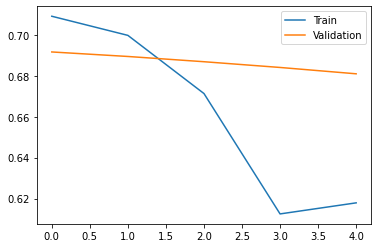

In [15]:
plot_train_val_loss(of_loss_hist, of_val_loss_hist)

In [16]:
epochs = 10
lr = 0.0001
model = CNN().to(device)

loss_hist, val_loss_hist = train(model, epochs, lr, train_files, val_files, transform)

Start training
[1/10] Loss: 0.34495. Epoch time: 47.2s.
[2/10] Loss: 0.33199. Epoch time: 48.0s.
[3/10] Loss: 0.32531. Epoch time: 47.3s.
[4/10] Loss: 0.33510. Epoch time: 46.0s.
[5/10] Loss: 0.33096. Epoch time: 47.1s.
[6/10] Loss: 0.33675. Epoch time: 47.8s.
[7/10] Loss: 0.32376. Epoch time: 47.8s.
[8/10] Loss: 0.31726. Epoch time: 46.7s.
[9/10] Loss: 0.34150. Epoch time: 46.9s.
[10/10] Loss: 0.33728. Epoch time: 47.8s.
Finished training after 472.7s.


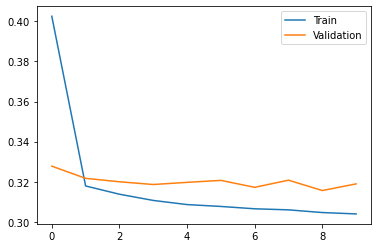

In [23]:
plot_train_val_loss(loss_hist, val_loss_hist)

# Interprete one predition

In [24]:
model.eval()
pred = model(example_X[0].to(device).unsqueeze(dim = 0))[0]>0

In [25]:
pred

tensor([False, False, False, False, False, False,  True, False, False, False,
        False, False, False, False, False, False, False, False, False],
       device='cuda:0')

In [26]:
df_labels.columns[1:][[x.item() for x in pred]]

Index(['drama'], dtype='object')

We know from above, the true classes are family and animation :(

# Compare accuracy of trained model, overfitt_model and init_model

In [50]:
def get_accuracy(model, val_files):
    correct = 0
    nr_pred_datapoints = 0
    model.eval()
    with torch.no_grad():
        for val_file in val_files:
            X = torch.load(image_path + f"\\{val_file}", device)
            X = transform(X)
            y = torch.load(r"E:\Letterboxd\Tensors BS 64 y" + f"\\{val_file}", device)
            out = model(X)

            correct += ((out>0) == y).sum().item()
            nr_pred_datapoints += y.size(0)

    nr_pred_classes = nr_pred_datapoints * 19
    
    print(f"{100*(correct/nr_pred_classes)}% of predicted classes are correct. This means not fully correctly classified data-points!")

In [51]:
get_accuracy(model, val_files)

88.32173425171001% of predicted classes are correct. This means not fully correctly classified data-points!


In [53]:
get_accuracy(init_model, val_files)

49.789306561936705% of predicted classes are correct. This means not fully correctly classified data-points!


In [54]:
get_accuracy(overfit_model, val_files)

65.76977713051055% of predicted classes are correct. This means not fully correctly classified data-points!


# Accuracy fully correct classified data-points